In [1]:
import torch
from diffusers import StableDiffusion3Pipeline
%matplotlib inline

/users/gmongaras/miniconda3/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2024-12-04 09:56:02.974577: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-12-04 09:56:11.170017: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT



===================================BUG REPORT===================================
Welcome to bitsandbytes. For bug reports, please run

python -m bitsandbytes

 and submit this information together with your error trace to: https://github.com/TimDettmers/bitsandbytes/issues
bin /users/gmongaras/miniconda3/lib/python3.10/site-packages/bitsandbytes/libbitsandbytes_cuda118.so
CUDA SETUP: CUDA runtime path found: /users/gmongaras/cuda-11.8/lib64/libcudart.so.11.0
CUDA SETUP: Highest compute capability among GPUs detected: 8.0
CUDA SETUP: Detected CUDA version 118
CUDA SETUP: Loading binary /users/gmongaras/miniconda3/lib/python3.10/site-packages/bitsandbytes/libbitsandbytes_cuda118.so...


/users/gmongaras/miniconda3/lib/python3.10/site-packages/bitsandbytes/cuda_setup/main.py:149: UserWarning: /hpc/mp/apps/conda did not contain ['libcudart.so', 'libcudart.so.11.0', 'libcudart.so.12.0'] as expected! Searching further paths...
  warn(msg)


In [2]:
# Read token from .env file
with open("../.env", "r") as f:
    token = f.read().strip()

pipe = StableDiffusion3Pipeline.from_pretrained("stabilityai/stable-diffusion-3-medium-diffusers", torch_dtype=torch.float16, cache_dir=".././cache", token=token)
pipe = pipe.to("cuda")

Loading pipeline components...: 100%|██████████| 9/9 [00:03<00:00,  2.96it/s]


In [3]:
# Get stable diffusion 3 config
config = pipe.transformer.config

In [4]:
# Reimport blocks
import importlib
import JointTransformerBlockMerge as JointTransformerBlockMerge
importlib.reload(JointTransformerBlockMerge)
JointTransformerBlockMerge = JointTransformerBlockMerge.JointTransformerBlock

In [5]:
# Replace attention in stable diffusion with the imported one
beg = 0
end = 23 # Skip last layer as it's not a transformer block
for i, layer in enumerate(pipe.transformer.transformer_blocks):
    if i >= beg and i < end:
        # Get state dict of the current layer
        state_dict = layer.state_dict().copy()
        # Old layer
        old_layer = layer
        # Add the new layer
        pipe.transformer.transformer_blocks[i] = JointTransformerBlockMerge(config.caption_projection_dim, config.num_attention_heads, config.attention_head_dim).to("cuda").to(torch.float16)
        # Load the state dict
        pipe.transformer.transformer_blocks[i].load_state_dict(state_dict)
        # Delete the old layer
        del old_layer, state_dict

In [9]:
# Reimport attention processor
import CustomProcessor_dist as CustomProcessor
import importlib
importlib.reload(CustomProcessor)
CustomProcessor = CustomProcessor.CustomProcessor

# Replace attention in stable diffusion with the imported one
num_skip = 0
for i, layer in enumerate(pipe.transformer.transformer_blocks):
    if i >= num_skip:
        layer.attn.set_processor(CustomProcessor())
        layer.attn.processor.idx = i


# Reset all distances
for layer in pipe.transformer.transformer_blocks:
    layer.attn.processor.query_dist = []
    layer.attn.processor.key_dist = []
    layer.attn.processor.value_dist = []

    layer.attn.processor.query_img_dist = []
    layer.attn.processor.key_img_dist = []
    layer.attn.processor.value_img_dist = []

    layer.attn.processor.query_text_dist = []
    layer.attn.processor.key_text_dist = []
    layer.attn.processor.value_text_dist = []

ModuleNotFoundError: No module named 'merging_tests'

In [ ]:
# Disable the attention processors
for layer in pipe.transformer.transformer_blocks:
    layer.attn.processor.merge = False

In [17]:
# Disable merging in the blocks
for i, layer in enumerate(pipe.transformer.transformer_blocks):
    if i < 20:
        layer.merge_attn = True
    else:
        layer.merge_attn = False
    layer.merge_ff = False
    layer.merge_per = 0.25
    layer.merge_method = "BipartiteSoftMatching"
    # layer.merge_method = "Random"
    if hasattr(layer, "hidden_states_merge"):
        del layer.hidden_states_merge

100%|██████████| 50/50 [00:07<00:00,  6.75it/s]


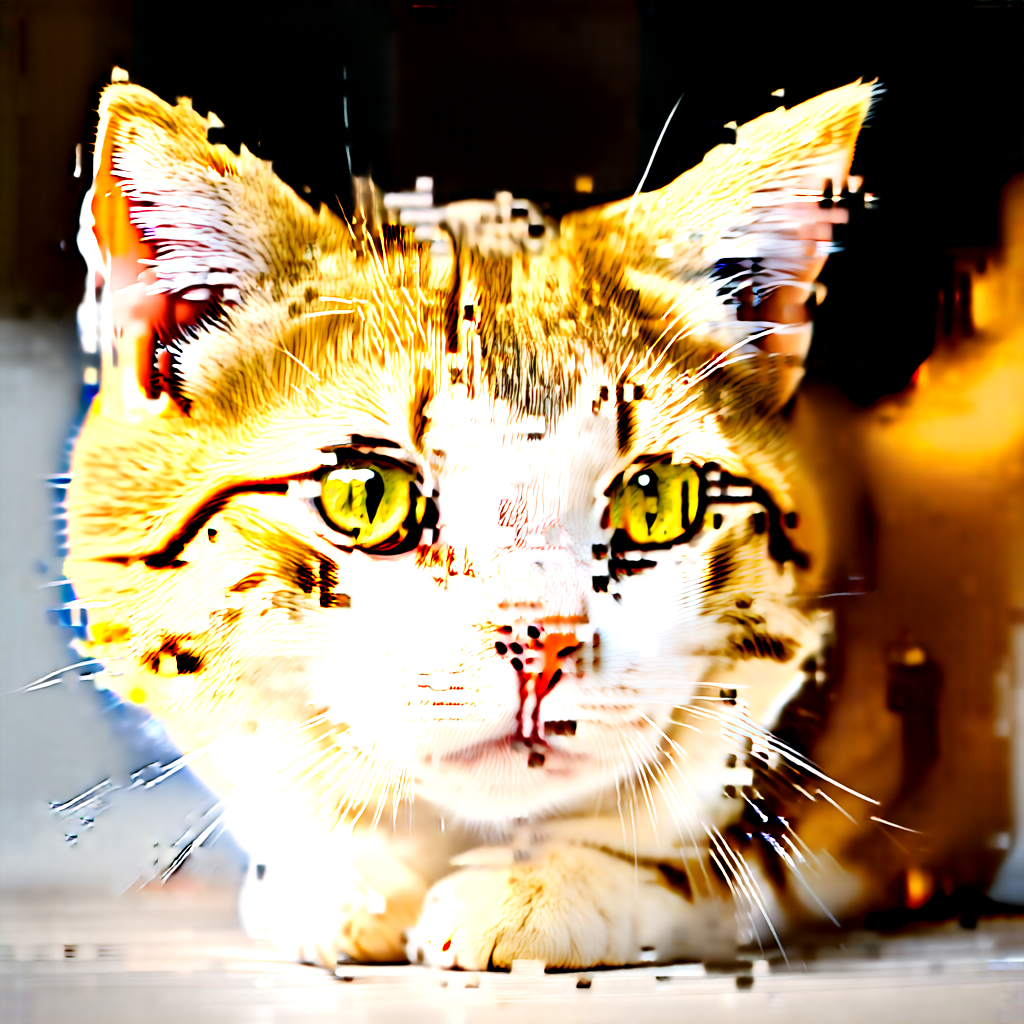

In [18]:
generator = torch.Generator(device="cuda").manual_seed(0)
image = pipe(
    ["A cat"],
    negative_prompt=[""],
    num_inference_steps=50,
    guidance_scale=7.5,
    height=1024,
    width=1024,
    
    generator=generator
).images[0]
image